In [2]:
# lets import the basic Libraries
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.model_selection import train_test_split,StratifiedKFold
from scipy.stats import ttest_ind
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score,classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from xgboost.sklearn import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression,RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb 
from scipy.stats import randint,truncnorm,uniform,expon,loguniform
import xgboost as xgb
# for Interactive Shells
from IPython.display import display

#filter warnings
import warnings
warnings.filterwarnings("ignore")
# setting up the chart size and background
plt.rcParams['figure.figsize'] = (16, 4)
plt.style.use('fivethirtyeight')

In [3]:
data=pd.read_csv("signal-data.csv")

In [4]:
data.shape

(1567, 592)

In [5]:
test=pd.read_excel("Future_predictions.xlsx")

In [6]:
test.shape

(18, 591)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [8]:
data["Pass/Fail"]=data["Pass/Fail"].replace({-1:0})


In [9]:
data["Pass/Fail"].dtypes

dtype('int64')

In [10]:
#to supress scientific notations
np.set_printoptions(suppress=True)

In [11]:
#printing %age of missing data
((data.isna().sum()/len(data))*100)

Time         0.000000
0            0.382897
1            0.446713
2            0.893427
3            0.893427
               ...   
586          0.063816
587          0.063816
588          0.063816
589          0.063816
Pass/Fail    0.000000
Length: 592, dtype: float64

In [12]:
((test.isna().sum()/len(test))*100)

Time    0.000000
0       0.000000
1       0.000000
2       0.000000
3       0.000000
          ...   
585     0.000000
586     5.555556
587     5.555556
588     5.555556
589     5.555556
Length: 591, dtype: float64

In [13]:
#It is very difficult to see the number of missing values in 590 columns 
#thus printing number of unique values of number of missing values to get an idea of atmost how many 
#different number of missing values are present in our dataset
data.isna().sum().unique()

array([   0,    6,    7,   14,    9,    2,    3,   10,    1,   24,    4,
        794,   12, 1341,   51, 1018,  715,    8,    5, 1429,  260,  273,
        949], dtype=int64)

In [14]:
test.isna().sum().unique()

array([ 0, 10, 18,  7,  1,  5], dtype=int64)

In [15]:
#fetching the index of columns which have missing values greater than 40%

def drop_na(df):
    drop_index=list()
    for column in df.columns:
        if (df[column].isna().sum()/len(df))*100 > 40:
            drop_index.append(column)
    #dropping the columns with have missing data greater than 40%  
    print("Shape of dataframe before dropping nan",df.shape)
    df.drop(drop_index,axis=1,inplace=True)  
    print("Shape of dataframe after dropping nan",df.shape)

In [15]:
#inspecting target column
data["Pass/Fail"].unique()

array([0, 1], dtype=int64)

In [17]:
data["Pass/Fail"].value_counts()

0    1463
1     104
Name: Pass/Fail, dtype: int64

## Feature Engineering

In [26]:
cdata=data.copy()

In [27]:
#deleting correlated columns
correlatedfeatures = set()
correlation_matrix = data.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85 and (correlation_matrix.columns[j] not in correlatedfeatures):
            colname = correlation_matrix.columns[i]
            correlatedfeatures.add(colname)

In [28]:
cdata.drop(correlatedfeatures,axis=1,inplace=True)

In [29]:
#deleting correlated columns
correlatedfeatures = set()
correlation_matrix = test.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85 and (correlation_matrix.columns[j] not in correlatedfeatures):
            colname = correlation_matrix.columns[i]
            correlatedfeatures.add(colname)

In [30]:

test.drop(correlatedfeatures,axis=1,inplace=True)

In [31]:
cdata.shape

(1567, 361)

In [32]:
test.shape

(18, 356)

In [22]:
#converting datatype of Time column from object to Date_time
cdata["Time"]=pd.to_datetime(cdata["Time"])

In [23]:
#Extracting month from Time
cdata["Month"]=cdata["Time"].dt.month

In [24]:
#extracting day from Time
cdata["day_of_month"]=cdata["Time"].dt.day

In [25]:
#Extracting hour from Time
cdata["Hour"]=cdata["Time"].dt.hour

In [26]:
#Extracting week from Time
cdata["weekday"]=cdata["Time"].dt.weekday

## EDA

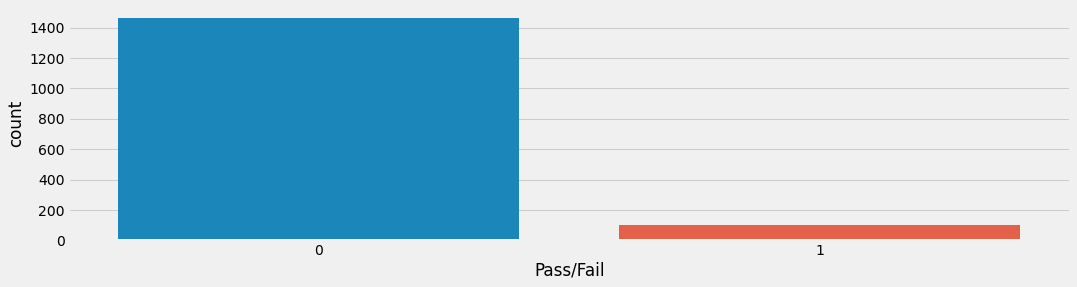

In [27]:
plt.figure()
sns.countplot(cdata["Pass/Fail"])

- we have an imbalanced dataset

In [28]:
cdata["Pass/Fail"].value_counts(normalize=True)

0    0.933631
1    0.066369
Name: Pass/Fail, dtype: float64

<Figure size 1152x288 with 0 Axes>

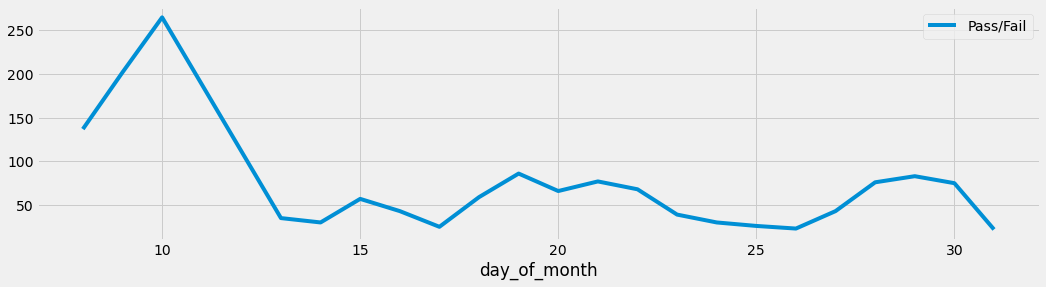

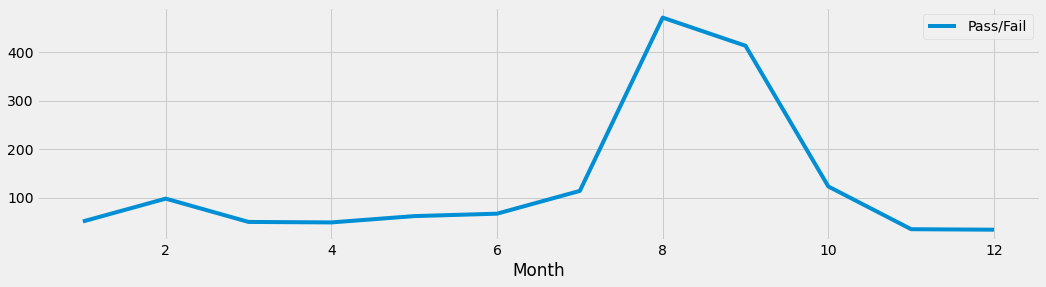

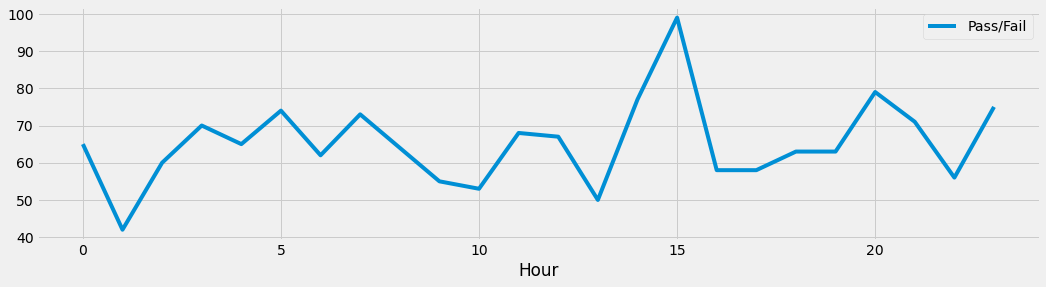

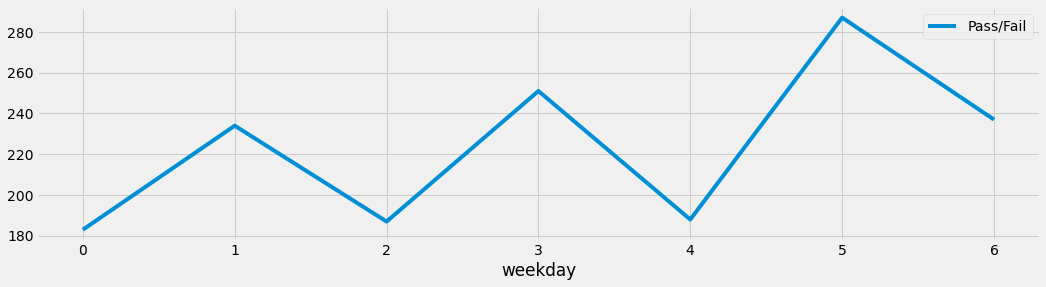

In [29]:
plt.figure()
cdata[["Pass/Fail","day_of_month"]].groupby("day_of_month").count().plot(kind="line")
cdata[["Pass/Fail","Month"]].groupby("Month").count().plot(kind="line")
cdata[["Pass/Fail","Hour"]].groupby("Hour").count().plot(kind="line")
cdata[["Pass/Fail","weekday"]].groupby("weekday").count().plot(kind="line")

- processes are giving maximum pass/fail yield between 15th to 16th hour of the day

- processes are giving maximum pass/fail yield in the month of August and september

- maximum pass/fail yields are obtained on 10th of every month
- After 10th, 9th of every month has the highest pass yield 
- After 10th, 8th of every month has the highest pass yield 
- maximum pass/fail yields are obtained in end of the week rather than in the middle of the week

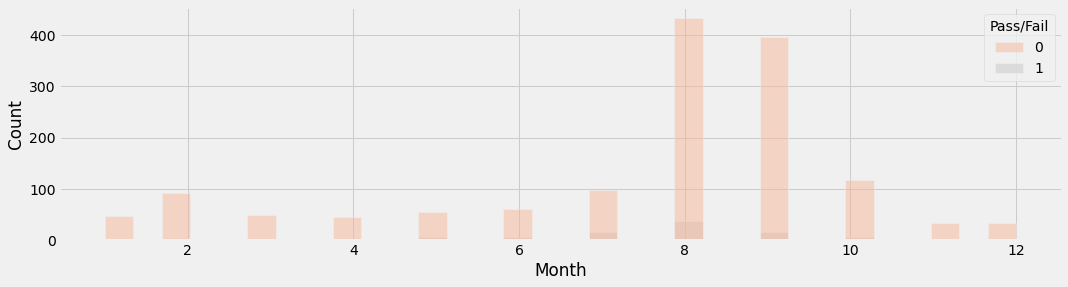

In [30]:
sns.histplot(x=cdata["Month"],hue=cdata["Pass/Fail"],palette="RdGy")

- We see that the failures (Pass/Fail=1) peak in August which is also the peak for pass.
- August and September are months with most pass and most failures as well
- The failures seem to subside from September onwards post some correction 
- During initial months failure are very less, then starts increasing from may month and peaks in august and then seems to subside september onwards

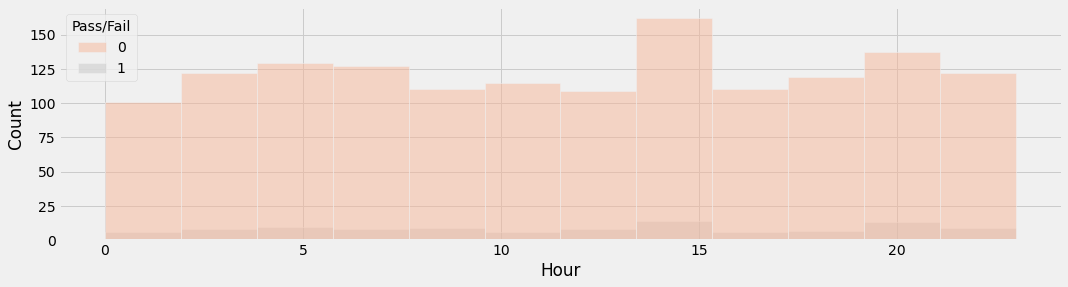

In [31]:
sns.histplot(x=cdata["Hour"],hue=cdata["Pass/Fail"],palette="RdGy")

- if we see,throughout the day pass rate is high as compared to fail rate.This can be because we have imbalance in our data
- there is no specific trend in pass or fail yeild if considered individually

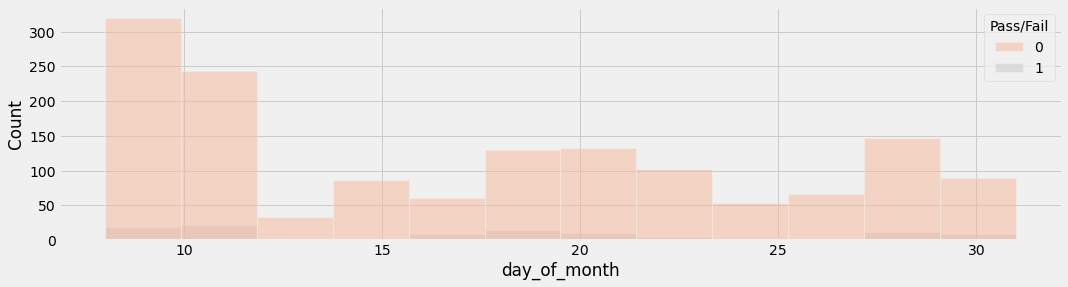

In [32]:
sns.histplot(x=cdata["day_of_month"],hue=cdata["Pass/Fail"],palette="RdGy");

- Proportion of fail rate is somewhat same throughout the month but pass rate is maximum from 10-12 of every month the starts decreasing from 13th onwards

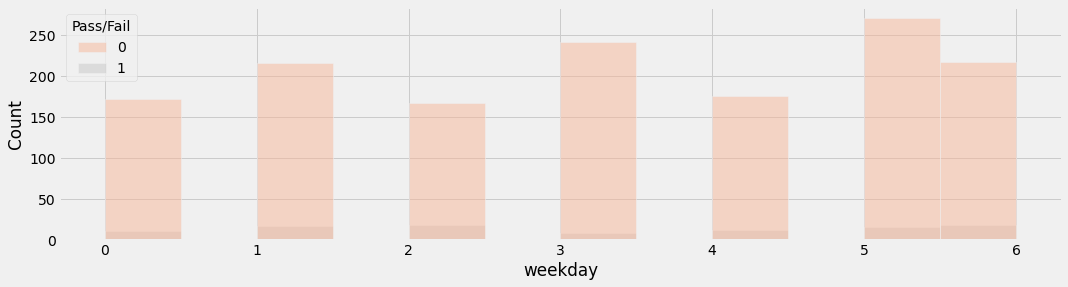

In [33]:
sns.histplot(x=cdata["weekday"],hue=cdata["Pass/Fail"],palette="RdGy")

- Proportion of fail rate is somewhat same throughout the week but pass rate is maximum at the end of te week.

In [34]:
#we have extracted the hour day and month from the Time column thus dropping the Time column from the dataframe
cdata.drop("Time",axis=1,inplace=True)

In [35]:
cdata.shape

(1567, 343)

In [36]:
# Checking for the outliers
#selecting 20 columns randomly to check if they have outliers
import random
def check_outliers(df):
    rand_cols=random.sample(list(df.columns), 20)
    for col in rand_cols:
        plt.figure()
        sns.boxplot(df[col])

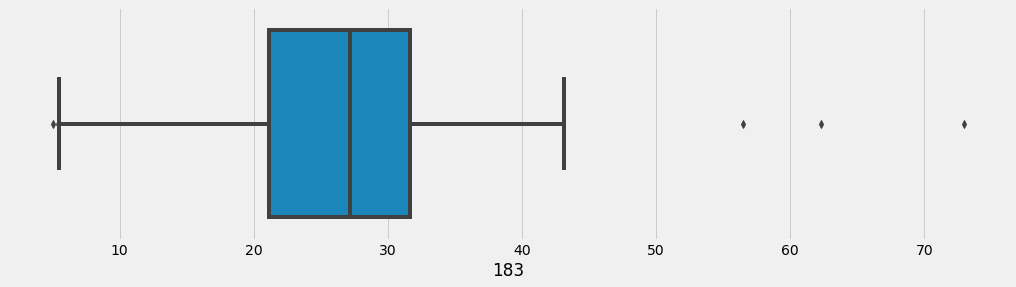

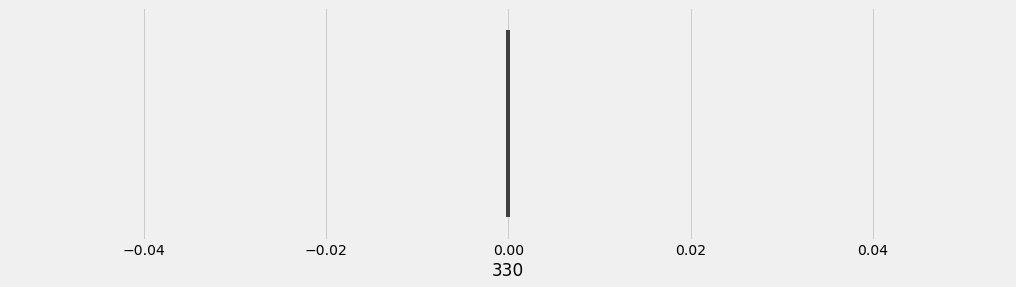

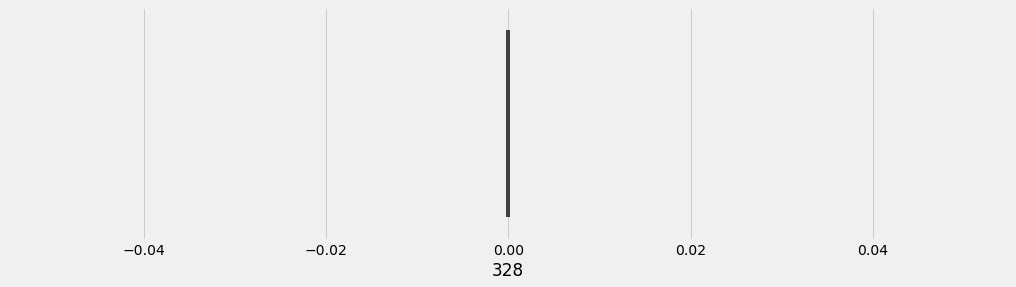

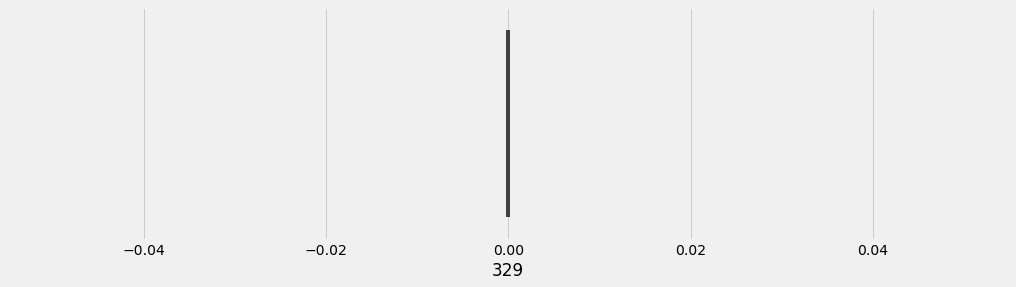

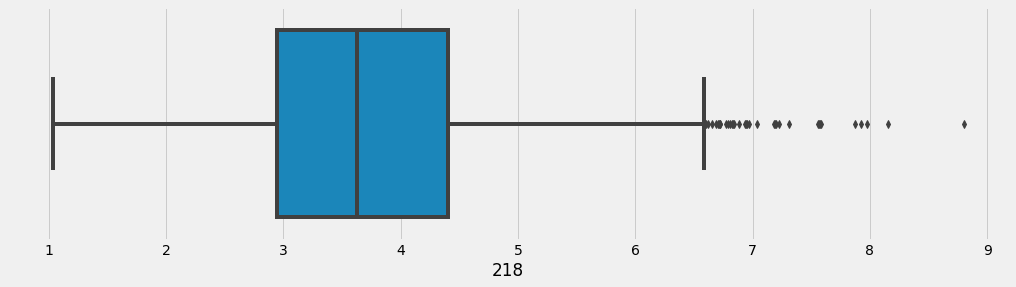

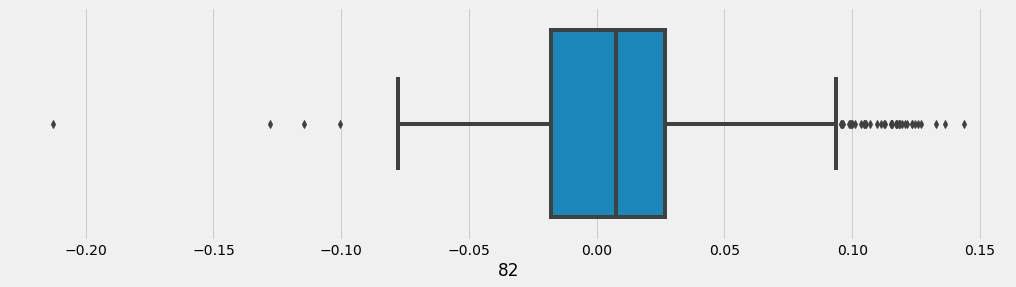

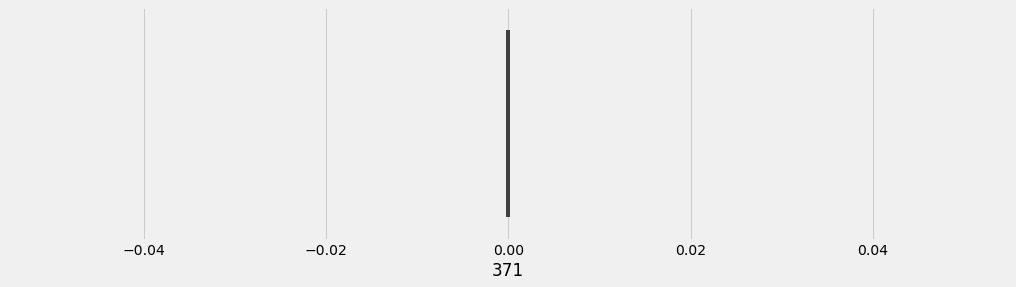

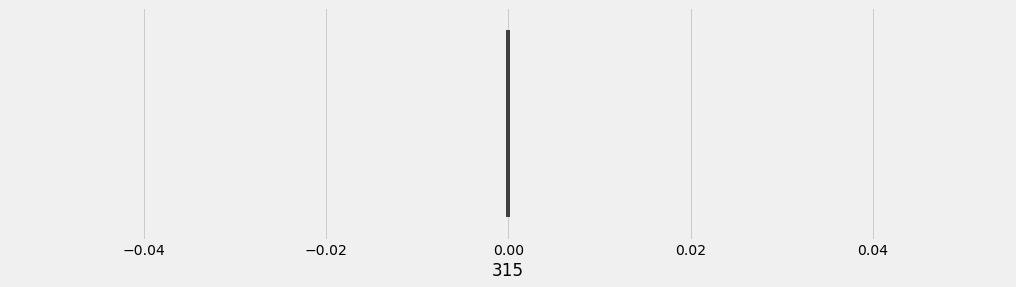

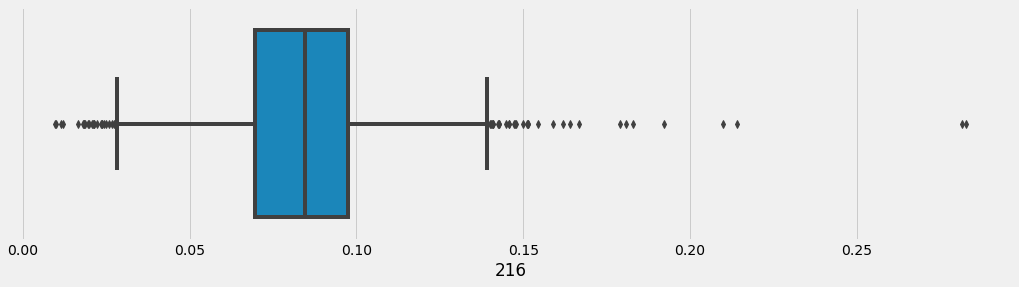

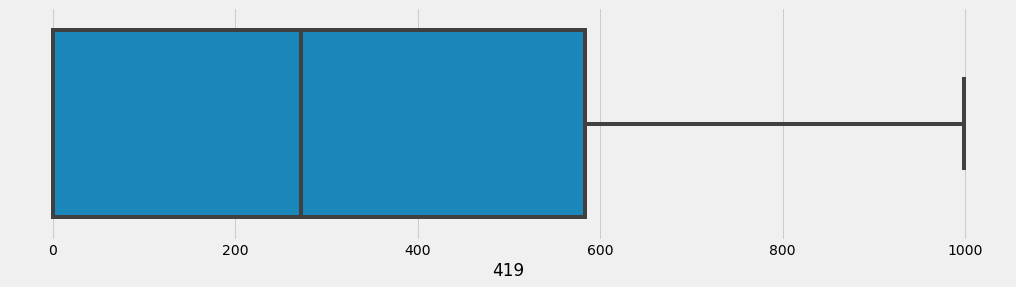

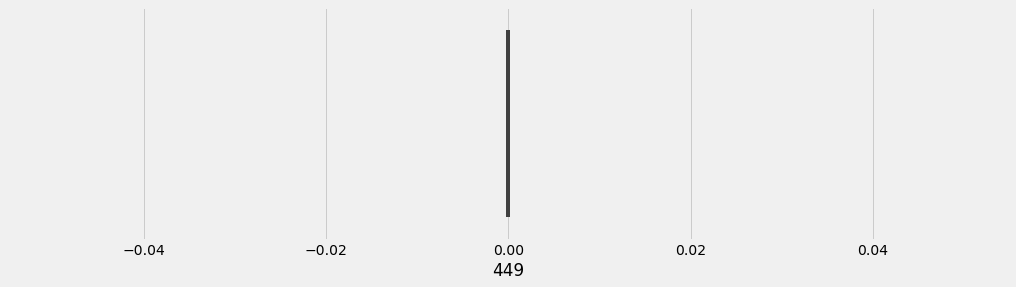

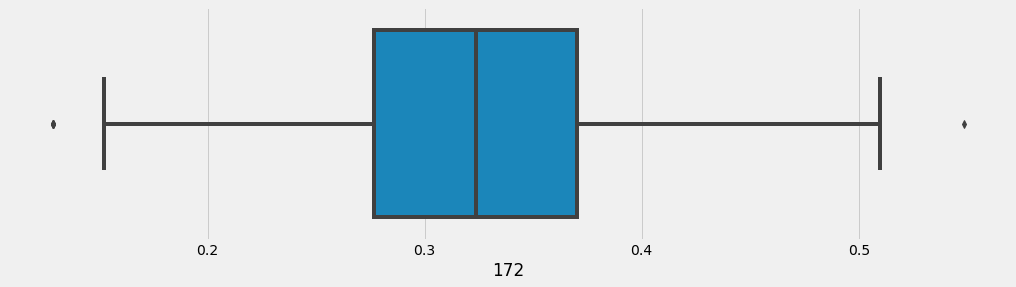

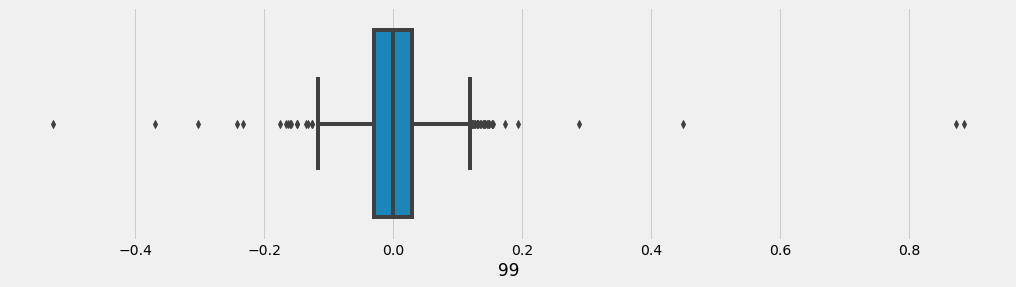

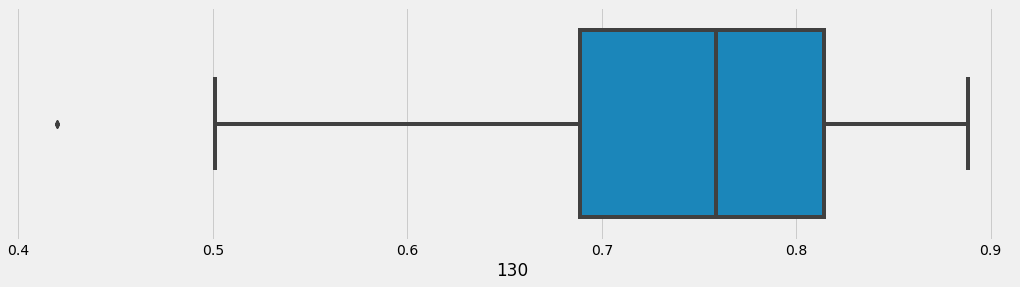

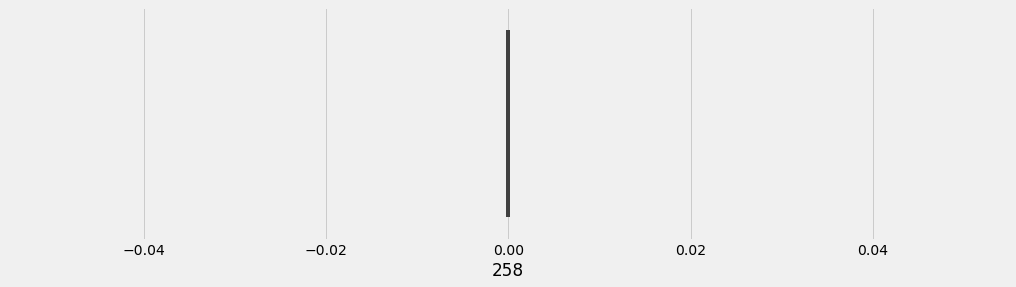

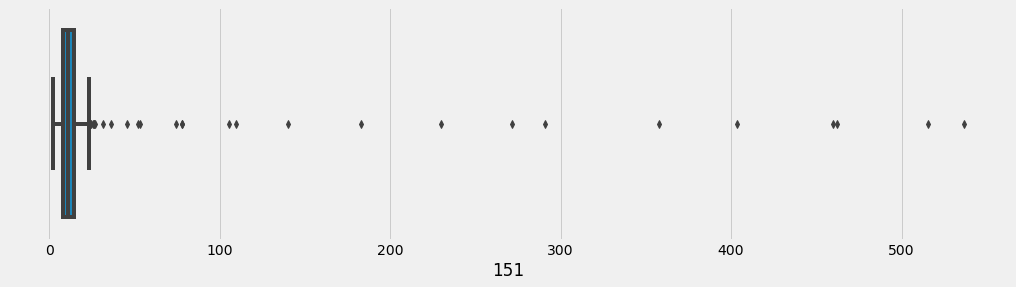

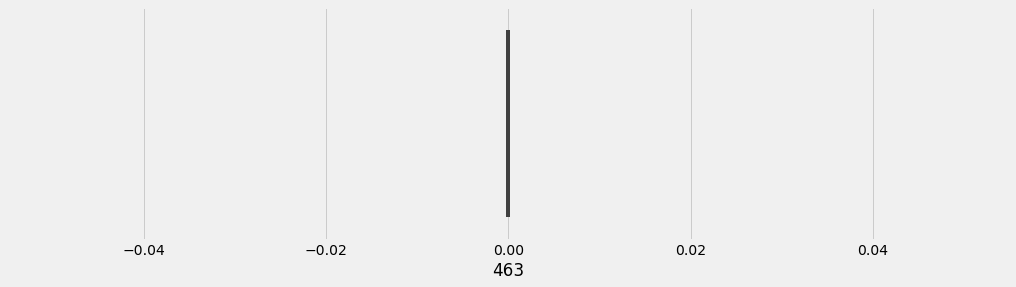

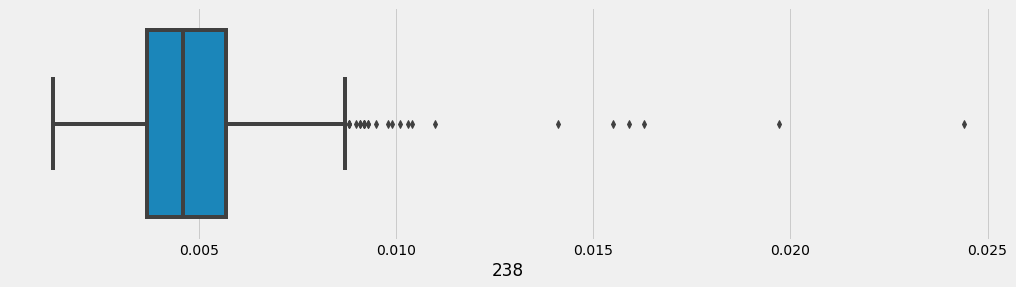

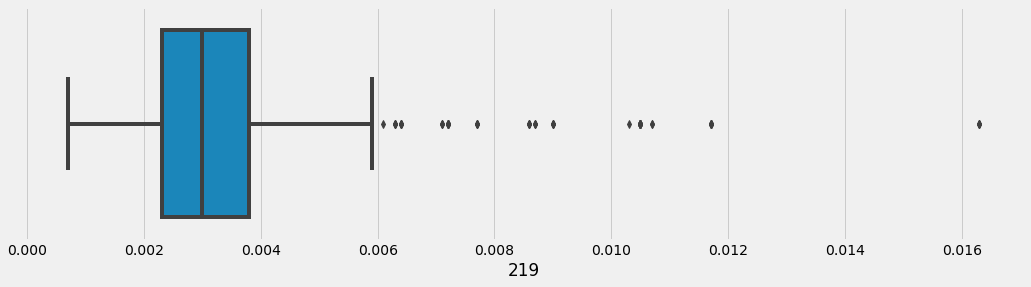

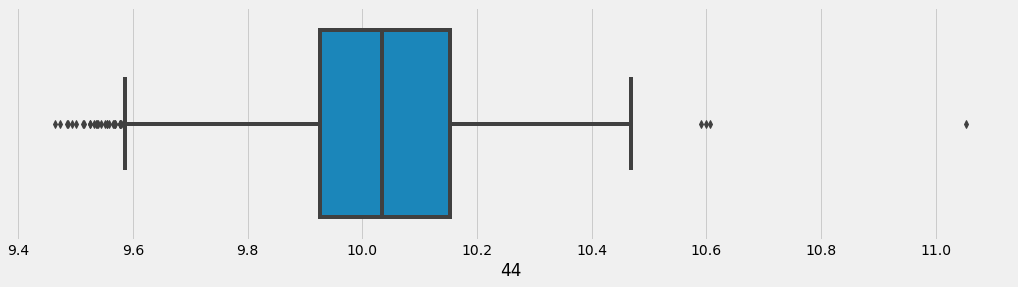

In [37]:
check_outliers(cdata)

- just by seeing only 20 columns we came to know that data has outliers

In [38]:
#removing outliers
def handle_outliers(df,feature):
    
    q1=np.percentile(df[feature],25)
    q3=np.percentile(df[feature],75)
    iqr=q3-q1
    fence_low=q1-1.5*iqr
    fence_high=q3+1.5*iqr
    outliers_low=df[feature][df[feature]<fence_low]
    outliers_high=df[feature][df[feature]>fence_high]

    if len(outliers_low) and len(outliers_high):
        df.loc[outliers_low.index.tolist(),feature]=fence_low
        df.loc[outliers_high.index.tolist(),feature]=fence_high
        
    elif len(outliers_low):
        df.loc[outliers_low.index.tolist(),feature]=fence_low
        
    elif len(outliers_high):
        df.loc[outliers_high.index.tolist(),feature]=fence_high

In [39]:
for col in cdata.columns:
    if col=="Pass/Fail":# dont want to do any outlier check in target column
        continue
    handle_outliers(cdata,col)

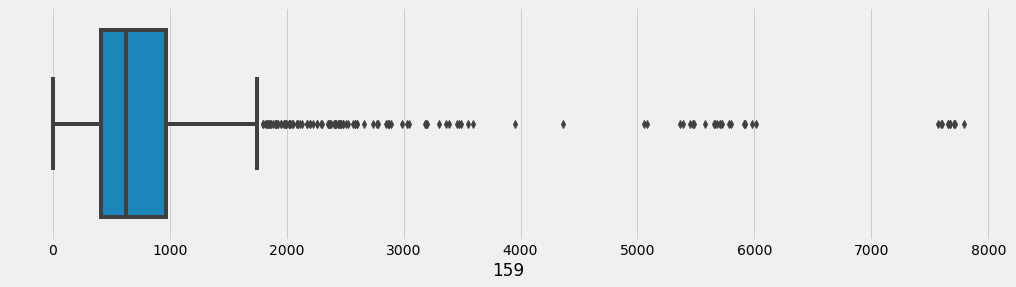

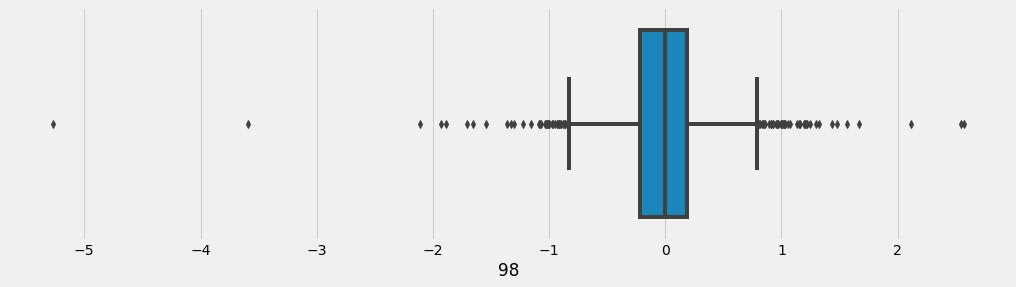

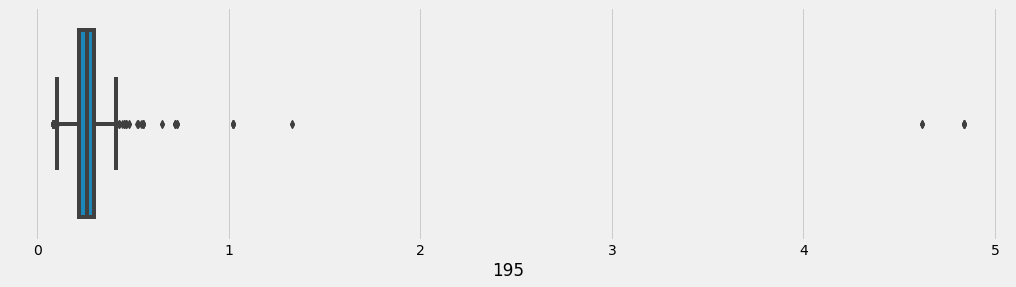

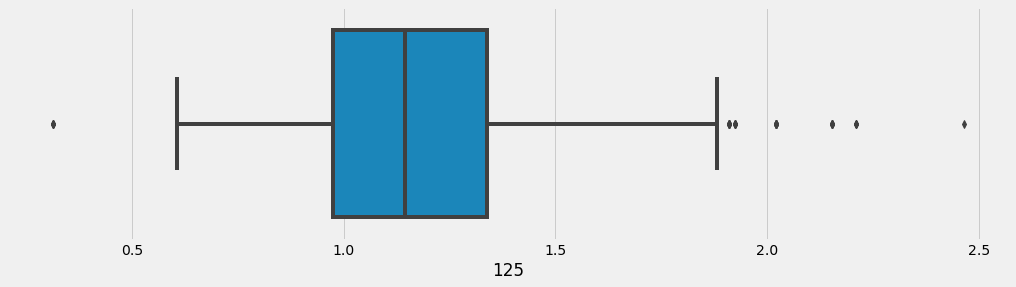

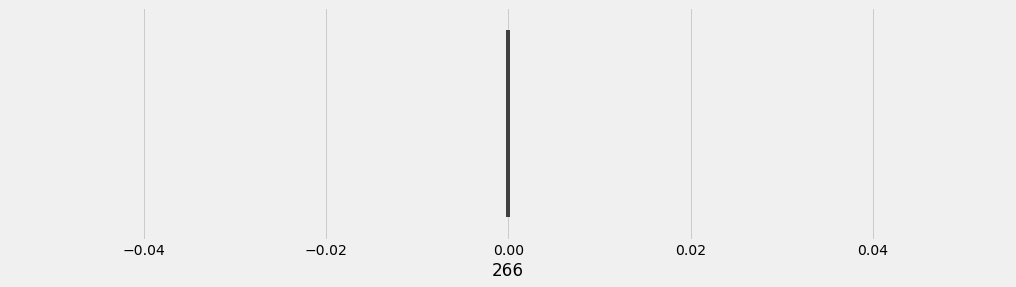

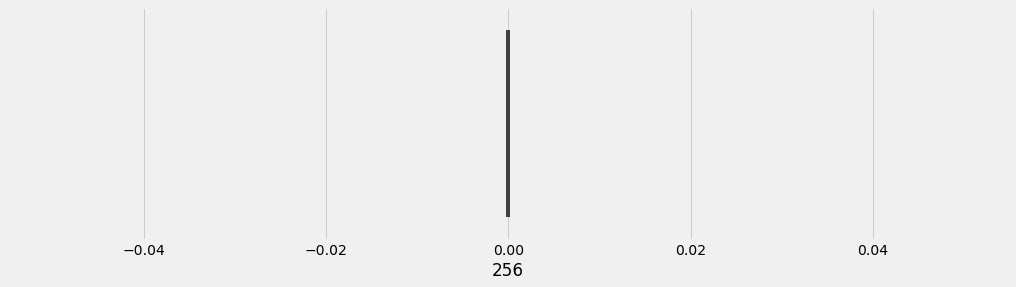

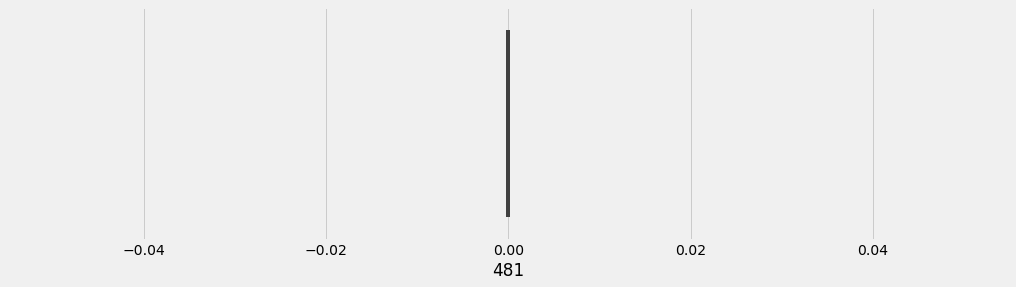

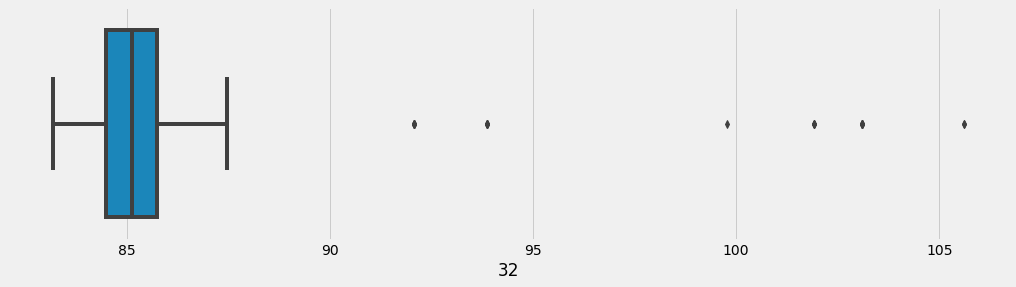

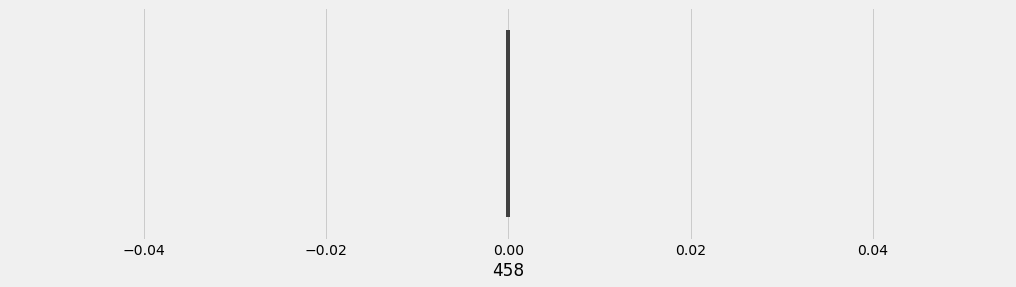

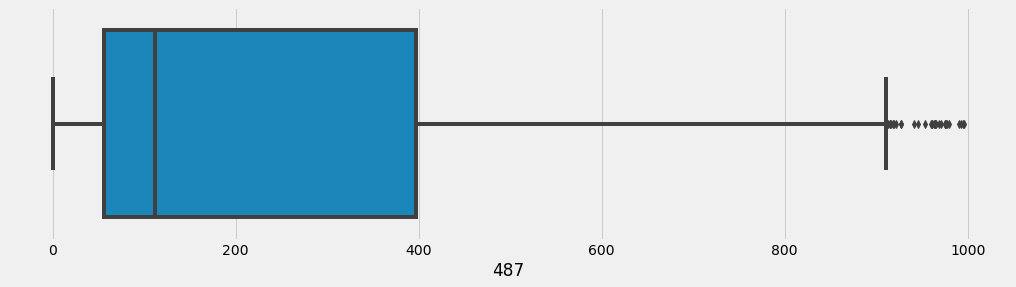

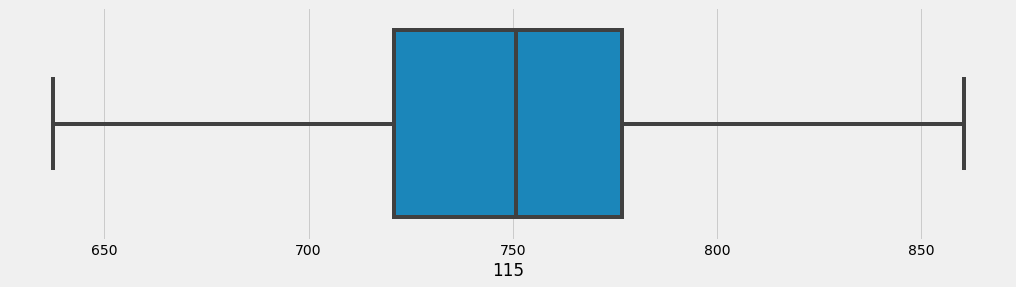

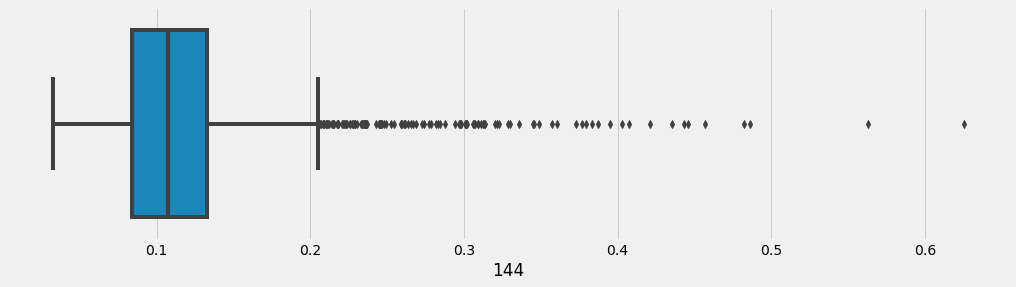

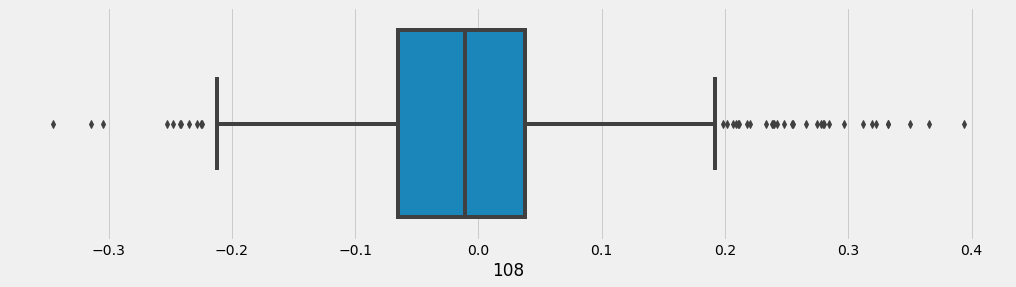

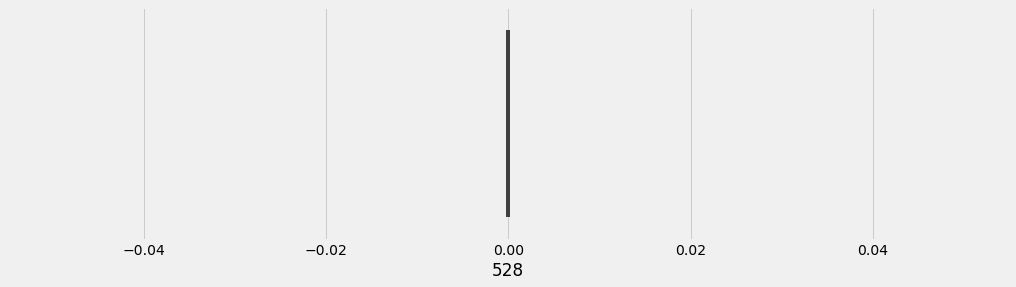

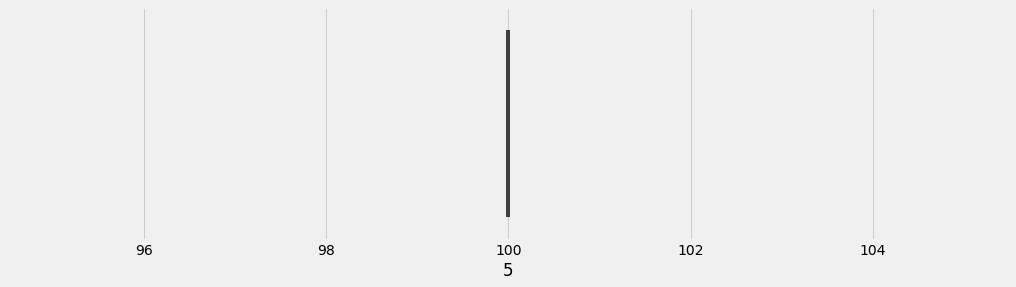

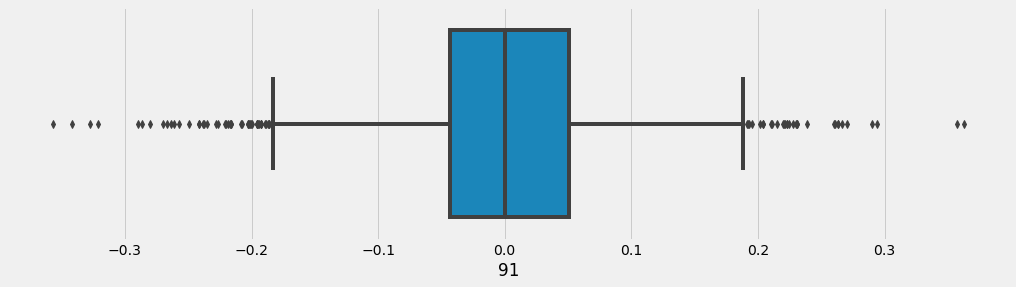

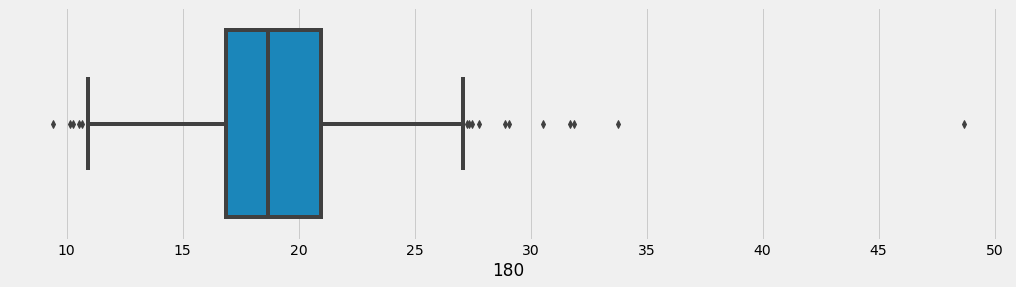

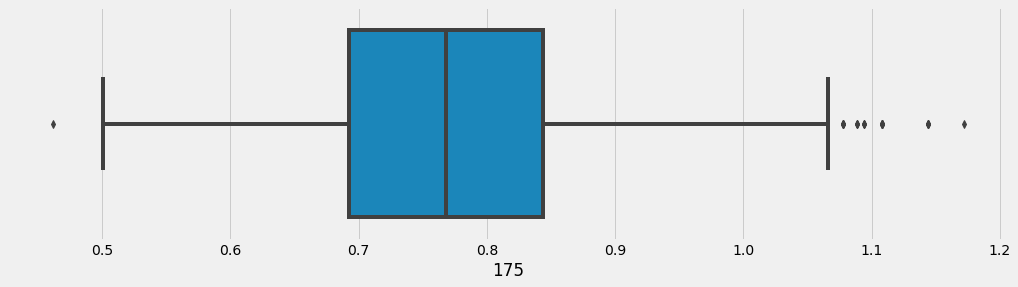

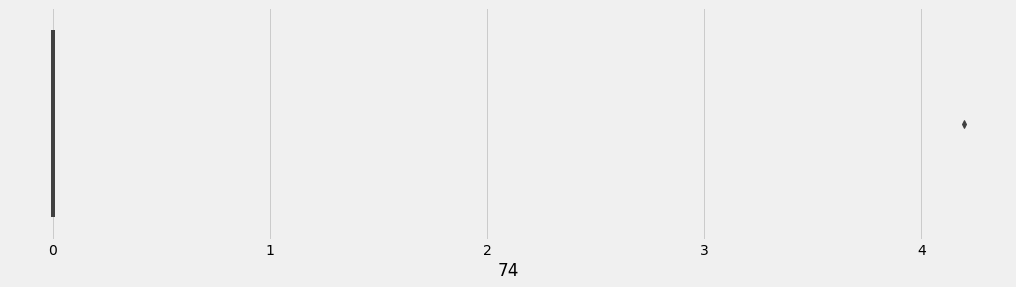

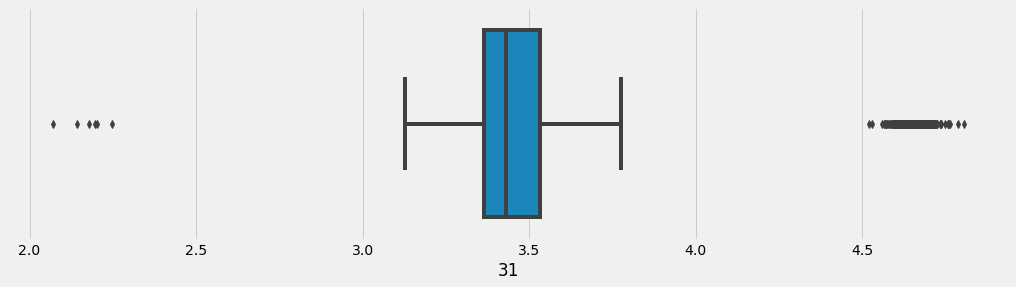

In [40]:
# rechecking if dataset have outliers
check_outliers(cdata)

- we can see our data is free from outliers
- now we can continue PCA

### Data PreProcessing and Model Building using pipeline

In [41]:
# Segregating features and target variable
X=cdata.drop("Pass/Fail",axis=1)
y=cdata["Pass/Fail"]


In [42]:
cdata.columns

Index(['0', '1', '2', '3', '4', '5', '6', '8', '9', '10',
       ...
       '582', '583', '586', '587', '589', 'Pass/Fail', 'Month', 'day_of_month',
       'Hour', 'weekday'],
      dtype='object', length=343)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, train_size =0.80,stratify=y,random_state=7)

In [44]:
X.shape,y.shape,X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1567, 342), (1567,), (1253, 342), (314, 342), (1253,), (314,))

### Checking if the train and test data have similar statistical characteristics when compared with original data

In [45]:
#Does the mean of Original Data differ significantly from the test and train data
#H0: the mean of Original Data and Train/test data is same
#H1: the mean of Original Data and Train/test data is significantly different
def test_stats(sample1,sample2):
    stats,p_value=ttest_ind(sample1,sample2,equal_var=False)
    if p_value.all()<0.05:
        print("Reject Null Hypothesis under the significance level of 0.05 \n the two sample mean are significantly different ")
    else:
        print("Failed to reject the null hypothesis \n the two sample mean are same")
     

In [46]:
print("Comparing X and X_train")
test_stats(X,X_train)
print("")

print("Comparing X and X_test")
test_stats(X,X_test)
print("")
print("Comparing y and y_train")
test_stats(y,y_train)
print("")

print("Comparing y and y_test")
test_stats(y,y_test)
print("")


Comparing X and X_train
Failed to reject the null hypothesis 
 the two sample mean are same

Comparing X and X_test
Failed to reject the null hypothesis 
 the two sample mean are same

Comparing y and y_train
Failed to reject the null hypothesis 
 the two sample mean are same

Comparing y and y_test
Failed to reject the null hypothesis 
 the two sample mean are same



- Thus it is establised with t-Test that train and test data have similar statistical characteristics when compared with original data

### Creating Objects for data Preprocessing

In [ ]:
#imputing the missing values using KNNImputer
impute=KNNImputer(n_neighbors=5,weights="uniform")
#scalling the data
scaler=StandardScaler()
#PCA
pca=PCA(n_components=.98)

### Creating evaluation function to plot a confusion matrix and Classification Report

In [48]:
def evaluation(y,y_hat,title="Confusion Matrix"):
    cm=confusion_matrix(y, y_hat, labels=[1, -1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["1","-1"]],
                  columns = [i for i in ["Predict 1","Predict -1"]])
    plt.figure(figsize = (7,5))
    sns.heatmap(df_cm, annot=True)
    print(sns.heatmap(df_cm,cmap="PuBu",annot=True,fmt="g"))
    plt.title(title)
    plt.show()
    print("======================Classification report==================")
    print(classification_report(y,y_hat))

In [49]:
def evaluate_models(models,X,y,cv):
    for model in models:
        score=cross_val_score(model,X,y,scoring="f1",cv=cv,n_jobs=-1)
        print(f"{model}:{score.mean():.3f} +/- {score.std():.3f}")

### Creating Holdout function to do cross validation using holdout method

In [50]:
def hold_out(pipeline):
    train_recall=[]
    val_recall=[]
    train_precision=[]
    val_precision=[]
    train_f1=[]
    val_f1=[]
    pipeline.fit(X_train,y_train)
    y_pred_trn=pipeline.predict(X_train)
    y_pred_val=pipeline.predict(X_test)
    
    train_recall= recall_score(y_train,y_pred_trn)
    train_precision = precision_score(y_train,y_pred_trn)
    train_f1 = f1_score(y_train,y_pred_trn)
    
    val_recall= recall_score(y_test,y_pred_val)
    val_precision = precision_score(y_test,y_pred_val)
    val_f1= f1_score(y_test,y_pred_val)
    
    print(evaluation(y_test,y_pred_val))
    print("Training Recall:   {}".format(train_recall))
    print("Training precision:   {}".format(train_precision))
    print("Training f1_score:   {}".format(train_f1)) 
                          
    print("validation Recall:   {}".format(val_recall))
    print("validation precision:   {}".format(val_precision))
    print("validation f1_score:   {}".format(val_f1)) 
    

### Creating cross_validate function to do Kfold cross validation

In [51]:
cv=StratifiedKFold(n_splits=10,random_state=7)
def cross_validate(pipeline,cv):
    train_recall=[]
    val_recall=[]
    train_precision=[]
    val_precision=[]
    train_f1=[]
    val_f1=[]
    for train_idx,val_idx in cv.split(X_train,y_train):
        X_trn,y_trn =X_train.iloc[train_idx],y_train.iloc[train_idx]
        X_val,y_val=X_train.iloc[val_idx],y_train.iloc[val_idx]
        pipeline.fit(X_trn,y_trn)
        
        y_hat_trn=pipeline.predict(X_trn)
        y_hat_val=pipeline.predict(X_val)
        
        train_recall.append(recall_score(y_trn,y_hat_trn))
        train_precision.append(precision_score(y_trn,y_hat_trn))
        train_f1.append(f1_score(y_trn,y_hat_trn)) 
                            
        val_recall.append(recall_score(y_val,y_hat_val))
        val_precision.append(precision_score(y_val,y_hat_val))
        val_f1.append(f1_score(y_val,y_hat_val))                    
    #labels=pipeline.classes_   
    #print(labels)
    print(evaluation(y_val,y_hat_val))
    print("Training Recall:   {}".format(np.mean(train_recall)))
    print("Training precision:   {}".format(np.mean(train_precision)))
    print("Training f1_score:   {}".format(np.mean(train_f1)))   
                          
    print("validation Recall:   {}".format(np.mean(val_recall)))
    print("validation precision:   {}".format(np.mean(val_precision)))
    print("validation f1_score:   {}".format(np.mean(val_f1))) 
    
    

### Creating loocv function to do Leaveoneout cross validation

In [52]:
def loocv(pipeline):
    train_recall=[]
    val_recall=[]
    train_precision=[]
    val_precision=[]
    train_f1=[]
    val_f1=[]
    loocv= LeaveOneOut()
    for train_idx,val_idx in loocv.split(X_train,y_train):
        X_trn,y_trn =X_train.iloc[train_idx],y_train.iloc[train_idx]
        X_val,y_val=X_train.iloc[val_idx],y_train.iloc[val_idx]
        pipeline.fit(X_trn,y_trn)
        
        y_hat_trn=pipeline.predict(X_trn)
        y_hat_val=pipeline.predict(X_val)
        
        train_recall.append(recall_score(y_trn,y_hat_trn))
        train_precision.append(precision_score(y_trn,y_hat_trn))
        train_f1.append(f1_score(y_trn,y_hat_trn)) 
                            
        val_recall.append(recall_score(y_val,y_hat_val))
        val_precision.append(precision_score(y_val,y_hat_val))
        val_f1.append(f1_score(y_val,y_hat_val))                    
    labels=pipeline.classes_   
    print(labels)
    print(evaluation(y_val,y_hat_val))
    print("Training Recall:   {}".format(np.mean(train_recall)))
    print("Training precision:   {}".format(np.mean(train_precision)))
    print("Training f1_score:   {}".format(np.mean(train_f1)))   
                          
    print("validation Recall:   {}".format(np.mean(val_recall)))
    print("validation precision:   {}".format(np.mean(val_precision)))
    print("validation f1_score:   {}".format(np.mean(val_f1))) 

In [53]:
y_train.value_counts()

0    1170
1      83
Name: Pass/Fail, dtype: int64

## Building Model
- In our Dataset we have a class Imbalance with  a ratio of 93:7
- There are many techniques that may be used to address an imbalanced classification problem. For eg
  - resampling the data
    - Over Sampling 
    - Under Sampling
  - class Weighted/Cost Sensitive Learning
    - Without resampling the data we can make classifier aware of the imbalance in the data by incorporating the weights of classes into cost function. we want to give higher weight to minority class and lower weight to majority class
  - Adjusting the threshold for classification

### 1) Logistic Regression
- Class Weight for Handling Class Imbalance
- RandomUnderSampler() for handling class Imbalance
- RandomOverSampler() for handling class Imbalance
- SMOTE() for handling class imbalance


In [54]:
# comparing different strategies to handle data imbalance with logistic regression
model1 = imblearn.pipeline.make_pipeline( impute,SMOTE(random_state=7),scaler,pca,LogisticRegression(random_state=7))
model2 = imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,LogisticRegression(random_state=7))
model3 = imblearn.pipeline.make_pipeline(impute,RandomOverSampler(random_state=7),scaler,pca,LogisticRegression(random_state=7))
model4 = imblearn.pipeline.make_pipeline(impute,scaler,pca,LogisticRegression(class_weight="balanced",random_state=7))
model5 = imblearn.pipeline.make_pipeline(impute,TomekLinks(),scaler,pca,LogisticRegression(random_state=7))
models=[model1,model2,model3,model4,model5]
evaluate_models(models,X_train,y_train,cv)



Pipeline(steps=[('knnimputer', KNNImputer()), ('smote', SMOTE(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('logisticregression', LogisticRegression(random_state=7))]):0.152 +/- 0.057
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomundersampler', RandomUnderSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('logisticregression', LogisticRegression(random_state=7))]):0.184 +/- 0.050
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('logisticregression', LogisticRegression(random_state=7))]):0.139 +/- 0.055
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('standardscaler', StandardS

- from above results it is evident that Logistic Regression with RandomUnderSampler is doing best among all the options

In [55]:
# initialising Logistic Regression
log_reg=LogisticRegression(random_state=7)
log_pipeline=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,log_reg)



### Cross Validation
 - Cross Validation is a statistical method used to estimate the skill of machine learning model. It is used to select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods. It helps us better use our data, and it gives us much more information about our algorithm performance on unseen data as well.Generally used cross validation Techniques are:
 - Hold Out Cross Validation
 - KFold Cross Validation
 - LOOCV

AxesSubplot(0.08,0.07;0.5568x0.81)


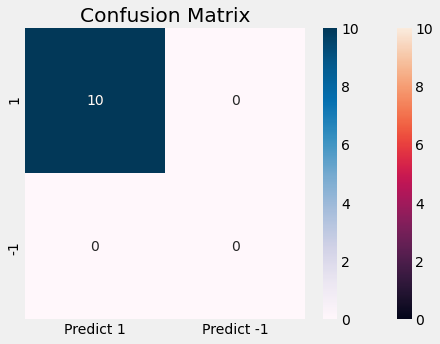

======================Classification report==================
              precision    recall  f1-score   support

           0       0.94      0.60      0.74       293
           1       0.08      0.48      0.14        21

    accuracy                           0.60       314
   macro avg       0.51      0.54      0.44       314
weighted avg       0.88      0.60      0.70       314

None
Training Recall:   1.0
Training precision:   0.16370808678500987
Training f1_score:   0.28135593220338984
validation Recall:   0.47619047619047616
validation precision:   0.07936507936507936
validation f1_score:   0.13605442176870747


In [56]:
#Evaluating Logistic Regression with RandomUnderSampler performance using Hold Out Cross Validation
hold_out(log_pipeline)

AxesSubplot(0.08,0.07;0.5568x0.81)


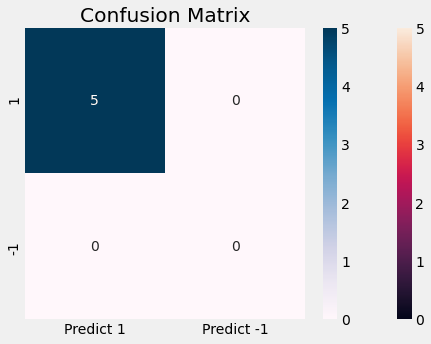

======================Classification report==================
              precision    recall  f1-score   support

           0       0.96      0.62      0.76       117
           1       0.10      0.62      0.18         8

    accuracy                           0.62       125
   macro avg       0.53      0.62      0.47       125
weighted avg       0.91      0.62      0.72       125

None
Training Recall:   1.0
Training precision:   0.1735961363706024
Training f1_score:   0.2956237964082272
validation Recall:   0.6208333333333333
validation precision:   0.10811643784296768
validation f1_score:   0.18393577506706232


In [57]:
#Evaluating Logistic Regression with RandomUnderSampler performance using KFold Cross Validation
cross_validate(log_pipeline,cv)

### RandomizedSearch Pipeline to find the most optimal parameters

In [59]:
def random_search(pipeline,X,y,distribution,cv):
    print(cv)
    randomsearch_model= RandomizedSearchCV(pipeline,distribution,n_iter=20,scoring="f1",cv=cv,random_state=7,n_jobs=-1)
    randomsearch_model.fit(X,y)
    print(pipeline.named_steps.keys())
    #getting best parameters
    print(randomsearch_model.best_params_)
    print("Best f1 ",randomsearch_model.best_score_)

### Lets Tune Logistic Regression model to find the most optimal parameters for the Logistic Regression model in the pipeline

In [60]:
#optimising Logistic regressor
C = loguniform(1e-5, 100)
penalty = ['l1', 'l2']
solver = ['newton-cg', 'lbfgs', 'liblinear']
distribution={'logisticregression__C':C,
            'logisticregression__penalty': penalty,
            'logisticregression__solver': solver
           }
#run randomized Search
print("Best params for logistic regression")
random_search(log_pipeline,X_train,y_train,distribution,cv)

Best params for logistic regression
StratifiedKFold(n_splits=10, random_state=7, shuffle=False)
dict_keys(['knnimputer', 'randomundersampler', 'standardscaler', 'pca', 'logisticregression'])
{'logisticregression__C': 0.005631137981158916, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best f1  0.1824512949528632


### Using Best Parameters to make Predictions using logistic regression with RandomUnderSampling
    

In [333]:
#retraining the model on the whole dataset(tarin part)
logreg_final= LogisticRegression(C=0.005631137981158916,penalty="l2",solver="liblinear")
logreg_pipe=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),SMOTE(random_state=7),scaler,pca,logreg_final)
#fitting the final model on whold data after getting best params
logreg_pipe.fit(X_train,y_train)
y_pred_logreg=logreg_pipe.predict(X_train)
logreg_pipe.named_steps


{'knnimputer': KNNImputer(),
 'randomundersampler': RandomUnderSampler(random_state=7),
 'smote': SMOTE(random_state=7),
 'standardscaler': StandardScaler(),
 'pca': PCA(n_components=0.98),
 'logisticregression': LogisticRegression(C=0.005631137981158916, solver='liblinear')}

### ROC_AUC

In [63]:
from sklearn.metrics import roc_auc_score,roc_curve
def roc(y_true,y_pred):
    print("Area under the curve   ",roc_auc_score(y_true,y_pred).round(3))
    fpr,tpr,threshold=roc_curve(y_true,y_pred, pos_label=1)
    # plot AUC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


Area under the curve    0.653


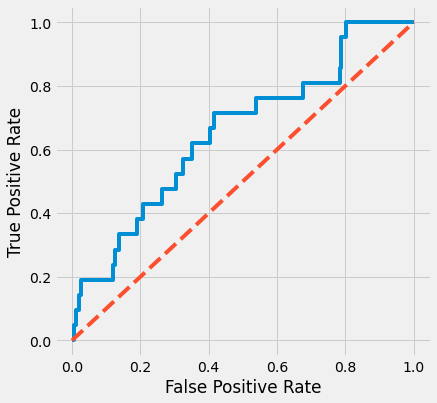

In [64]:
roc(y_test,logreg_pipe.predict_proba(X_test)[:,1])

#### As Value of area under the curve and ROC Curve shows that model has poor performance. Thus we will  try to change the threshold values to increase the performance of the model

In [65]:
#Next, we can then define a set of thresholds to evaluate the probabilities. 
#In this case, we will test all thresholds between 0.0 and 1.0 with a step size of 0.001,
#that is, we will test 0.0, 0.001, 0.002, 0.003, and so on to 0.999.
# define thresholds

f1=[]
y_pred_classes=[]
thresholds = np.arange(0, 1, 0.001)
for t in thresholds:
    y_pred_class=[]
    for prob in y_pred_proba:
        if prob>=t:
            y_pred_class.append(1)
        else:
            y_pred_class.append(0)
    f1.append(f1_score(y_test,y_pred_class))
    y_pred_classes.append(y_pred_class)

In [66]:
#fetching the index of maximum f1 score 
idx=np.argmax(f1)
best_thresh=thresholds[idx]
best_y_pred=y_pred_classes[idx]
print("Maximum f1 score",np.max(f1))

Maximum f1 score 0.24242424242424246


In [67]:
print("Best threshold",best_thresh)

Best threshold 0.685


In [68]:
print("Classification Report",classification_report(y_test,best_y_pred))

Classification Report               precision    recall  f1-score   support

           0       0.94      0.97      0.96       293
           1       0.33      0.19      0.24        21

    accuracy                           0.92       314
   macro avg       0.64      0.58      0.60       314
weighted avg       0.90      0.92      0.91       314



As we can see by changing the threshold values though the models f1 score a improved from 18 to 24 but at the same time the recall value has drastically reduecd from 57 to 19 .
In our dataset with pass signal as (0) and fail signal as (1) products, we can imagine that not detecting a fail signal will cost more to the company than wrongly labelling pass signal as fail. Now, predicting 0 when true label is 1 is far worse than predicting 1 when true label is 0. Thus we will go by the model with high recall value.

### 2) RandomForest classifier
- Class Weight for Handling Class Imbalance
- RandomUnderSampler() for handling class Imbalance
- RandomOverSampler() for handling class Imbalance
- SMOTE() for handling class imbalance

In [69]:
# comparing different strategies to handle data imbalance with logistic regression
model1 = imblearn.pipeline.make_pipeline( impute,SMOTE(random_state=7),scaler,pca,RandomForestClassifier(random_state=7))
model2 = imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,RandomForestClassifier(random_state=7))
model3 = imblearn.pipeline.make_pipeline(impute,RandomOverSampler(random_state=7),scaler,pca,RandomForestClassifier(random_state=7))
model4 = imblearn.pipeline.make_pipeline(impute,scaler,pca,BalancedRandomForestClassifier(class_weight="balanced",random_state=7))
model5 = imblearn.pipeline.make_pipeline(impute,TomekLinks(),scaler,pca,RandomForestClassifier(random_state=7))
models=[model1,model2,model3,model4,model5]
evaluate_models(models,X_train,y_train,cv)



Pipeline(steps=[('knnimputer', KNNImputer()), ('smote', SMOTE(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))]):0.000 +/- 0.000
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomundersampler', RandomUnderSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))]):0.142 +/- 0.044
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=7))]):0.000 +/- 0.000
Pipeline(steps=

- from above results it is evident that RandomForest Classifier with RandomUnderSampler is doing best among all the options

In [70]:
# initialising Logistic Regression
rfc=RandomForestClassifier(random_state=7)
rfc_pipeline=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,rfc)

### Cross Validation

Cross Validation is a statistical method used to estimate the skill of machine learning model. It is used to select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods. It helps us better use our data, and it gives us much more information about our algorithm performance on unseen data as well.Generally used cross validation Techniques are:
- Hold Out Cross Validation
- KFold Cross Validation
- LOOCV

AxesSubplot(0.08,0.07;0.5568x0.81)


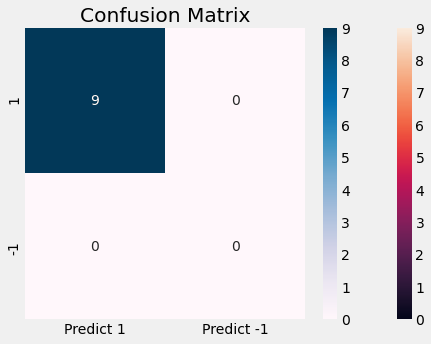

======================Classification report==================
              precision    recall  f1-score   support

           0       0.94      0.69      0.80       293
           1       0.09      0.43      0.15        21

    accuracy                           0.67       314
   macro avg       0.52      0.56      0.47       314
weighted avg       0.89      0.67      0.75       314

None
Training Recall:   1.0
Training precision:   0.21119592875318066
Training f1_score:   0.34873949579831937
validation Recall:   0.42857142857142855
validation precision:   0.09
validation f1_score:   0.1487603305785124


In [71]:
#Evaluating Random Forest Classifier using Hold Out Cross Validation
hold_out(rfc_pipeline)


AxesSubplot(0.08,0.07;0.5568x0.81)


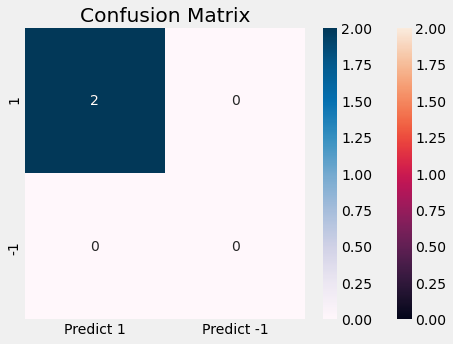

======================Classification report==================
              precision    recall  f1-score   support

           0       0.92      0.57      0.71       117
           1       0.04      0.25      0.07         8

    accuracy                           0.55       125
   macro avg       0.48      0.41      0.39       125
weighted avg       0.86      0.55      0.66       125

None
Training Recall:   1.0
Training precision:   0.18784489685658895
Training f1_score:   0.3158693319540067
validation Recall:   0.43194444444444446
validation precision:   0.08564312611061814
validation f1_score:   0.1423987831387522


In [72]:
#Evaluating Random Forest Classifier using KFold Cross Validation
cross_validate(rfc_pipeline,cv)

### Lets Tune RandomForest Classifier model to find the most optimal parameters for the RandomForest Classifier model in the pipeline



In [73]:

# specify parameters and distributions to sample from
distribution = { "randomforestclassifier__n_estimators": randint(100, 500),
                 "randomforestclassifier__max_depth": randint(10, 50),
                 "randomforestclassifier__max_features": ['sqrt', 'log2'],
                 "randomforestclassifier__min_samples_split": uniform(0.01, 0.199),
                 #"randomforestclassifier__min_samples_leaf": randint(1, 11),
                 "randomforestclassifier__bootstrap": [True,False],
                 "randomforestclassifier__criterion": ["gini", "entropy"]}

# run randomized search
print("Best params for Random Forest Classifier")
random_search(rfc_pipeline,X_train,y_train,distribution,cv)

Best params for Random Forest Classifier
StratifiedKFold(n_splits=10, random_state=7, shuffle=False)
dict_keys(['knnimputer', 'randomundersampler', 'standardscaler', 'pca', 'randomforestclassifier'])
{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 45, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_split': 0.08024269482293454, 'randomforestclassifier__n_estimators': 319}
Best f1  0.19327796779088993


### Using Best Parameters to make Predictions using RandomForest Classifier with RandomUnderSampling

In [74]:
#retraining the model on the whole dataset(tarin part)
rfc_final= RandomForestClassifier(n_estimators=319,max_depth=45,max_features='log2',min_samples_split=0.08024269482293454,criterion="gini",bootstrap="False",random_state=7)
rfc_pipe=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,rfc_final)
#fitting the final model on whold data after getting best params
rfc_pipe.fit(X_train,y_train)
y_pred_rfc=rfc_pipe.predict(X_test)
rfc_pipe.named_steps


{'knnimputer': KNNImputer(),
 'randomundersampler': RandomUnderSampler(random_state=7),
 'standardscaler': StandardScaler(),
 'pca': PCA(n_components=0.98),
 'randomforestclassifier': RandomForestClassifier(bootstrap='False', max_depth=45, max_features='log2',
                        min_samples_split=0.08024269482293454, n_estimators=319,
                        random_state=7)}

In [75]:
print("Classification Report",classification_report(y_test,y_pred_rfc))


Classification Report               precision    recall  f1-score   support

           0       0.96      0.74      0.83       293
           1       0.13      0.57      0.22        21

    accuracy                           0.73       314
   macro avg       0.55      0.65      0.53       314
weighted avg       0.90      0.73      0.79       314



Area under the curve    0.692


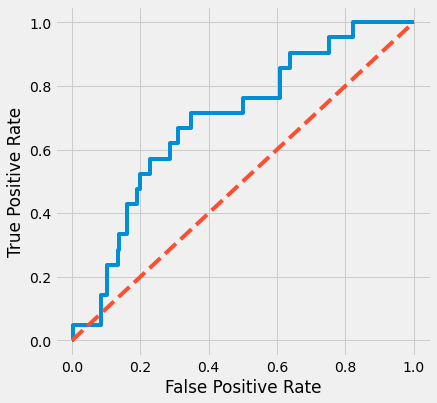

In [76]:
roc(y_test,rfc_pipe.predict_proba(X_test)[:,1])

As we can see that Randomized search give us the best score as 0.193. After implementing the model with the best parameters fetched from Cross Validation we are getting the f1 score for class of intrest as 22% and the corresponding recall and precision as 57% and 13%. In our dataset with pass signal as (0) and fail signal as (1) products, we can imagine that not detecting a fail signal will cost more to the company than wrongly labelling pass signal as fail. Now, predicting 0 when true label is 1 is far worse than predicting 1 when true label is 0. Thus we will go by the model with high recall value.

## 3) Support Vector Machines
- Class Weight for Handling Class Imbalance
- RandomUnderSampler() for handling class Imbalance
- RandomOverSampler() for handling class Imbalance
- SMOTE() for handling class imbalance


In [80]:
# comparing different strategies to handle data imbalance with Support Vector Machines
model1 = imblearn.pipeline.make_pipeline( impute,SMOTE(random_state=7),scaler,pca,SVC(probability=True,random_state=7))
model2 = imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,SVC(probability=True,random_state=7))
model3 = imblearn.pipeline.make_pipeline(impute,RandomOverSampler(random_state=7),scaler,pca,SVC(probability=True,random_state=7))
model4 = imblearn.pipeline.make_pipeline(impute,scaler,pca,SVC(probability=True,class_weight="balanced",random_state=7))
model5 = imblearn.pipeline.make_pipeline(impute,TomekLinks(),scaler,pca,SVC(probability=True,random_state=7))
models=[model1,model2,model3,model4,model5]
evaluate_models(models,X_train,y_train,cv)

Pipeline(steps=[('knnimputer', KNNImputer()), ('smote', SMOTE(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('svc', SVC(probability=True, random_state=7))]):0.020 +/- 0.060
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomundersampler', RandomUnderSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('svc', SVC(probability=True, random_state=7))]):0.209 +/- 0.064
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('svc', SVC(probability=True, random_state=7))]):0.062 +/- 0.095
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
                ('pca', PC

- from above results it is evident that Support Vector Machine with RandomUnderSampler is doing best among all the options

### Building SVC


In [81]:
svc_pipeline=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,SVC(random_state=7))

### Cross Validating SCV 
Cross Validation is a statistical method used to estimate the skill of machine learning model. It is used to select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods. It helps us better use our data, and it gives us much more information about our algorithm performance on unseen data as well.Generally used cross validation Techniques are:
- Hold Out Cross Validation
- KFold Cross Validation
- LOOCV

AxesSubplot(0.08,0.07;0.5568x0.81)


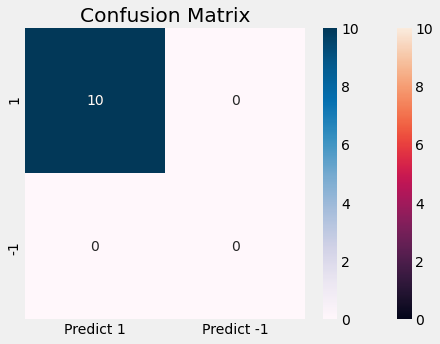

======================Classification report==================
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       293
           1       0.11      0.48      0.17        21

    accuracy                           0.70       314
   macro avg       0.53      0.59      0.49       314
weighted avg       0.89      0.70      0.77       314

None
Training Recall:   0.9879518072289156
Training precision:   0.22282608695652173
Training f1_score:   0.3636363636363636
validation Recall:   0.47619047619047616
validation precision:   0.10638297872340426
validation f1_score:   0.17391304347826086


In [82]:
hold_out(svc_pipeline)

AxesSubplot(0.08,0.07;0.5568x0.81)


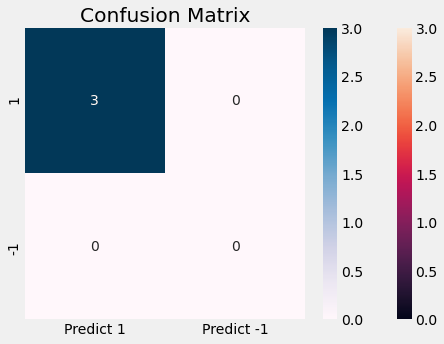

======================Classification report==================
              precision    recall  f1-score   support

           0       0.94      0.68      0.79       117
           1       0.07      0.38      0.12         8

    accuracy                           0.66       125
   macro avg       0.51      0.53      0.45       125
weighted avg       0.88      0.66      0.74       125

None
Training Recall:   0.9986666666666666
Training precision:   0.23412066022962424
Training f1_score:   0.378189638089112
validation Recall:   0.5416666666666667
validation precision:   0.13097388645358204
validation f1_score:   0.2089963215257932


In [83]:
cross_validate(svc_pipeline,cv)

### Lets Tune Support Vector Classifier model to find the most optimal parameters for the Support Vector Classifier​ model in the pipeline

In [84]:
svc_param_grid={ 'svc__C': expon(scale=.01),
                 'svc__gamma':expon(scale=.01),   
                 
                 "svc__kernel":['linear', 'poly', 'rbf', 'sigmoid']
                }

In [85]:
from sklearn.utils.fixes import loguniform
print("Best params for Support Vector Classifier ")
random_search(svc_pipeline,X_train,y_train,svc_param_grid,cv)

Best params for Support Vector Classifier 
StratifiedKFold(n_splits=10, random_state=7, shuffle=False)
dict_keys(['knnimputer', 'randomundersampler', 'standardscaler', 'pca', 'svc'])
{'svc__C': 0.001979350875867577, 'svc__gamma': 0.0015398573128477054, 'svc__kernel': 'linear'}
Best f1  0.19782135508843585


### Using Best Parameters to make Predictions using  Support Vector Classifier model with RandomUnderSampling

In [179]:
final_svc=SVC(C=0.2,gamma="scale",probability=True,kernel="rbf",random_state=7)
pipe_svc=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,final_svc)
pipe_svc.fit(X_train,y_train)
y_pred_svc=pipe_svc.predict(X_test)
print(pipe_svc.named_steps)

{'knnimputer': KNNImputer(), 'randomundersampler': RandomUnderSampler(random_state=7), 'standardscaler': StandardScaler(), 'pca': PCA(n_components=0.98), 'svc': SVC(C=0.2, probability=True, random_state=7)}


In [86]:
#randomized
final_svc=SVC(C=0.001979350875867577,gamma=0.0015398573128477054,probability=True,kernel="linear",random_state=7)
pipe_svc=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,final_svc)
pipe_svc.fit(X_train,y_train)
y_pred_svc=pipe_svc.predict(X_test)
print(pipe_svc.named_steps)


{'knnimputer': KNNImputer(), 'randomundersampler': RandomUnderSampler(random_state=7), 'standardscaler': StandardScaler(), 'pca': PCA(n_components=0.98), 'svc': SVC(C=0.001979350875867577, gamma=0.0015398573128477054, kernel='linear',
    probability=True, random_state=7)}


In [87]:
print("========== Classification report================\n",classification_report(y_test,y_pred_svc))

========== Classification report================
               precision    recall  f1-score   support

           0       0.95      0.69      0.80       293
           1       0.11      0.52      0.18        21

    accuracy                           0.68       314
   macro avg       0.53      0.61      0.49       314
weighted avg       0.90      0.68      0.76       314



In [88]:
y_pred_proba=pipe_svc.decision_function(X_test)

In [89]:
from sklearn.metrics import roc_auc_score,roc_curve
def roc(y_true,y_pred):
    print("Area under the curve   ",roc_auc_score(y_true,y_pred).round(3))
    fpr,tpr,threshold=roc_curve(y_true,y_pred, pos_label=1)
    # plot AUC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

Area under the curve    0.654


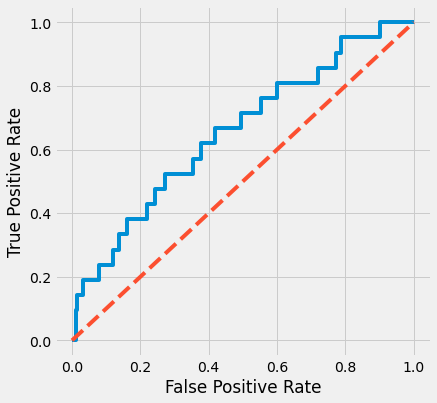

In [90]:
roc(y_test,y_pred_proba)

- As we can see that Randomized search give us the best score as 0.197. After implementing the model with the best parameters fetched from Cross Validation we are getting the f1 score for class of intrest as 18% and the corresponding recall and precision as 52% and 11%. In our dataset with pass signal as (0) and fail signal as (1) products, we can imagine that not detecting a fail signal will cost more to the company than wrongly labelling pass signal as fail. Now, predicting 0 when true label is 1 is far worse than predicting 1 when true label is 0. Thus we will go by the model with high recall value.

## 5)Light GBM

- Class Weight for Handling Class Imbalance
- RandomUnderSampler() for handling class Imbalance
- RandomOverSampler() for handling class Imbalance
- SMOTE() for handling class imbalance



In [374]:
# comparing different strategies to handle data imbalance with logistic regression
model1 = imblearn.pipeline.make_pipeline( impute,SMOTE(random_state=7),scaler,pca,lgb.LGBMClassifier(random_state=7))
model2 = imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,lgb.LGBMClassifier(random_state=7))
model3 = imblearn.pipeline.make_pipeline(impute,RandomOverSampler(random_state=7),scaler,pca,lgb.LGBMClassifier(random_state=7))
model4 = imblearn.pipeline.make_pipeline(impute,scaler,pca,lgb.LGBMClassifier(random_state=7))
model5 = imblearn.pipeline.make_pipeline(impute,TomekLinks(),scaler,pca,lgb.LGBMClassifier(random_state=7))
models=[model1,model2,model3,model4,model5]
evaluate_models(models,X_train,y_train,cv)

Pipeline(steps=[('knnimputer', KNNImputer()), ('smote', SMOTE(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('lgbmclassifier', LGBMClassifier(random_state=7))]):0.000 +/- 0.000
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomundersampler', RandomUnderSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('lgbmclassifier', LGBMClassifier(random_state=7))]):0.149 +/- 0.056
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomoversampler', RandomOverSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('lgbmclassifier', LGBMClassifier(random_state=7))]):0.000 +/- 0.000
Pipeline(steps=[('knnimputer', KNNImputer()),
                ('standardscaler', StandardScaler()),
              

-Only LGBMClassifier with RandomUnderSampler is performing best amongst all the models

## Building LGBMClassifier

In [395]:
lgb_pipeline=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,lgb.LGBMClassifier(random_state=7))

### Cross Validating LGBMClassifier
Cross Validation is a statistical method used to estimate the skill of machine learning model. It is used to select a model for a given predictive modeling problem because it is easy to understand, easy to implement, and results in skill estimates that generally have a lower bias than other methods. It helps us better use our data, and it gives us much more information about our algorithm performance on unseen data as well.Generally used cross validation Techniques are:
- Hold Out Cross Validation
- KFold Cross Validation
- LOOCV

AxesSubplot(0.08,0.07;0.5568x0.81)


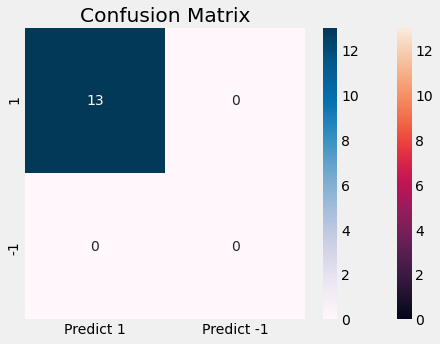

======================Classification report==================
              precision    recall  f1-score   support

           0       0.96      0.67      0.79       293
           1       0.12      0.62      0.20        21

    accuracy                           0.67       314
   macro avg       0.54      0.65      0.50       314
weighted avg       0.90      0.67      0.75       314

None
Training Recall:   1.0
Training precision:   0.18949771689497716
Training f1_score:   0.3186180422264875
validation Recall:   0.6190476190476191
validation precision:   0.11926605504587157
validation f1_score:   0.2


In [396]:
hold_out(lgb_pipeline)

AxesSubplot(0.08,0.07;0.5568x0.81)


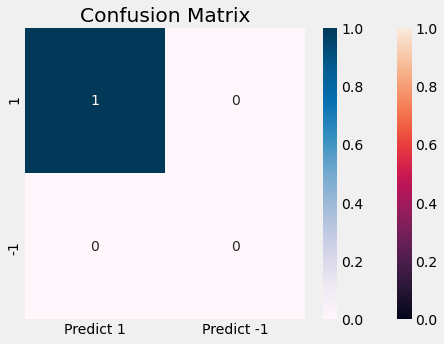

======================Classification report==================
              precision    recall  f1-score   support

           0       0.91      0.62      0.73       117
           1       0.02      0.12      0.04         8

    accuracy                           0.58       125
   macro avg       0.47      0.37      0.39       125
weighted avg       0.85      0.58      0.69       125

None
Training Recall:   1.0
Training precision:   0.17632016437578843
Training f1_score:   0.29966240210784145
validation Recall:   0.5180555555555555
validation precision:   0.08735040528473599
validation f1_score:   0.14916024684816523


In [379]:
cross_validate(lgb_pipeline,cv)

### Lets Tune LGBMClassifier model to find the most optimal parameters 

In [400]:
lgb_param_grid = {
    'lgbmclassifier__boosting_type': ['gbdt', 'goss', 'dart'],
    'lgbmclassifier__num_leaves': list(range(20, 150)),
    'lgbmclassifier__learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'lgbmclassifier__subsample_for_bin': list(range(20000, 300000, 20000)),
    'lgbmclassifier__min_child_samples': list(range(20, 500, 5)),
    'lgbmclassifier__is_unbalance': [True, False]
}

In [401]:
random_search(lgb_pipeline,X_train,y_train,lgb_param_grid,cv)

StratifiedKFold(n_splits=10, random_state=7, shuffle=False)
dict_keys(['knnimputer', 'randomundersampler', 'standardscaler', 'pca', 'lgbmclassifier'])
{'lgbmclassifier__subsample_for_bin': 220000, 'lgbmclassifier__num_leaves': 73, 'lgbmclassifier__min_child_samples': 70, 'lgbmclassifier__learning_rate': 0.030321646977040304, 'lgbmclassifier__is_unbalance': True, 'lgbmclassifier__boosting_type': 'gbdt'}
Best f1  0.15380935885918146


### Using Best Parameters to make Predictions 

In [402]:
final_lgb=lgb.LGBMClassifier(subsample_for_bin=220000,num_leaves=73,min_child_samples=70,
                                                    learning_rate=0.030321646977040304,is_unbalance=True,boosting_type='gbdt' )
pipe_lgb=imblearn.pipeline.make_pipeline(impute,RandomUnderSampler(random_state=7),scaler,pca,final_xgb)

In [403]:
pipe_lgb.fit(X_train,y_train)


Pipeline(steps=[('knnimputer', KNNImputer()),
                ('randomundersampler', RandomUnderSampler(random_state=7)),
                ('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.98)),
                ('lgbmclassifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.030321646977040304,
                                min_child_samples=70, num_leaves=73,
                                subsample_for_bin=220000))])

In [404]:
y_pred_lgb=pipe_lgb.predict(X_test)
print("=======Classification Report==========\n",classification_report(y_test,y_pred_lgb))

=======Classification Report==========
               precision    recall  f1-score   support

           0       0.94      0.53      0.67       293
           1       0.07      0.52      0.13        21

    accuracy                           0.53       314
   macro avg       0.51      0.52      0.40       314
weighted avg       0.88      0.53      0.64       314



### ROC_AUC

Area under the curve    0.569


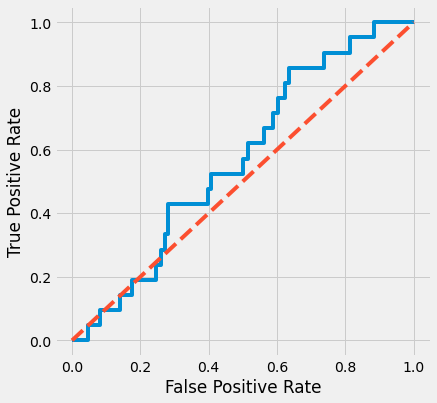

In [426]:
roc(y_test,pipe_lgb.predict_proba(X_test)[:,1])

### Compare Different models

Logistic Regression: 0.182451 (0.056443)
Random Forest Classifier: 0.161338 (0.052683)
Support vector Machine: 0.197821 (0.059712)
Light GBM: 0.153809 (0.046033)


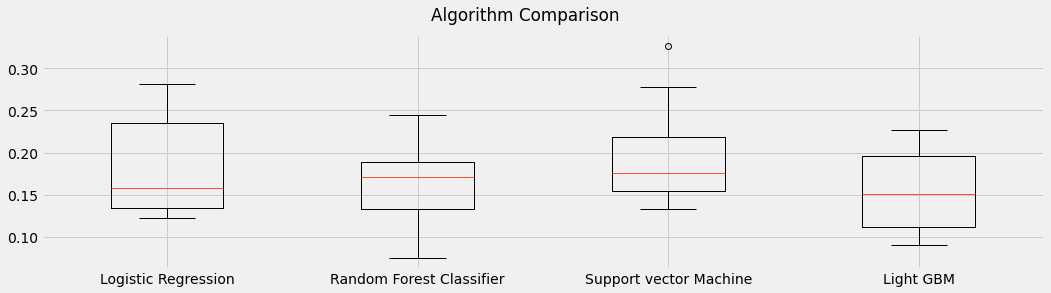

In [425]:
eval_models=[]
eval_models.append(("Logistic Regression",logreg_pipe))
eval_models.append(("Random Forest Classifier",rfc_pipe))
eval_models.append(("Support vector Machine",pipe_svc))
eval_models.append(("Light GBM",pipe_lgb))
# evaluate each model in turn
results = []
names = []
scoring = 'f1'
for name, model in eval_models:
    kfold = StratifiedKFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- Random Forest Classifier is doing Better Amongst all the classifier coz it has least standard deviation as compared to other models

### Pickle Random Forest Classifier

In [431]:
import pickle
with open("rfc_pipe.pickle","wb")as file:
    pickle.dump(rfc_pipe,file)

In [501]:
n_iterations = 200        # Number of bootstrap samples to create
n_size = int(len(data) * 0.50)    # picking only 50 % of the given data in every bootstrap sample
values=np.array(cData)
# run bootstrap
stats = list()
for i in range(n_iterations):
	# prepare train and test sets
	train = resample(values, n_samples=n_size)  # Sampling with replacement 
	test = np.array([x for x in values if x.tolist() not in train.tolist()])  # picking rest of the data not considered in sample
    # fit model
	model = rfc_pipe()
	model.fit(train[:,:-1], train[:,-1])
    # evaluate model
	predictions = model.predict(test[:,:-1])
	score = accuracy_score(test[:,-1], predictions)    # caution, overall accuracy score can mislead when classes are imbalanced
	print(score)
	stats.append(score)

NameError: name 'cData' is not defined

### Doing prediction on unseen data

In [458]:
test=pd.read_excel(r"Future_predictions.xlsx")

In [459]:
test.shape

(18, 591)

In [465]:
with open("rfc_pipe.pickle", "rb") as file:
    model_rbf = pickle.load(file) 
    

In [460]:
drop_index=list()
for idx,value in enumerate(((test.isna().sum()/len(test))*100)):
    if value >40:
        drop_index.append(idx)  

In [461]:
#deleting correlated columns
correlatedfeatures = set()
correlation_matrix = test.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.85 and (correlation_matrix.columns[j] not in correlatedfeatures):
            colname = correlation_matrix.columns[i]
            correlatedfeatures.add(colname)

In [462]:
test.drop(correlatedfeatures,axis=1,inplace=True)
#converting datatype of Time column from object to Date_time
cdata["Time"]=pd.to_datetime(test["Time"])
#Extracting month from Time
cdata["Month"]=test["Time"].dt.month
#extracting day from Time
cdata["day_of_month"]=test["Time"].dt.day
#Extracting hour from Time
cdata["Hour"]=test["Time"].dt.hour
#Extracting week from Time
cdata["weekday"]=test["Time"].dt.weekday

In [467]:
test.shape

(18, 355)

In [468]:
X_train.shape

(1253, 342)

In [464]:
test.drop("Time",axis=1,inplace=True)

In [466]:
model_rbf.predict(test)

ValueError: Incompatible dimension between the fitted dataset and the one to be transformed

In [439]:
print("Classification Report",classification_report(y_test,y_pred_rfc))


Classification Report               precision    recall  f1-score   support

           0       0.96      0.74      0.83       293
           1       0.13      0.57      0.22        21

    accuracy                           0.73       314
   macro avg       0.55      0.65      0.53       314
weighted avg       0.90      0.73      0.79       314



## Comments

- random Forest calssifier is performing best amongst all the classifiers
- the data is highly imbalanced
- As we can see that f1 score for class of interest is 22. After implementing the model with the best parameters fetched from Cross Validation we are getting the f1 score for class of intrest as 22% and the corresponding recall and precision as 57% and 13%. In our dataset with pass signal as (0) and fail signal as (1) products, we can imagine that not detecting a fail signal will cost more to the company than wrongly labelling pass signal as fail. Now, predicting 0 when true label is 1 is far worse than predicting 1 when true label is 0. Thus we will go by the model with high recall value.